# Import Libraries

In [7]:
data_name = 'cadillac'
load_dir = f'Data/{data_name}/'
save_dir = f'Data/{data_name}/1_VTK_surface'
# Specify test set numbers manually
test_numbers = [73,42,23,19,104]  # <-- replace with your desired test indices

In [8]:

# import bpy
import os
import re
# import mathutils
import shutil
import numpy as np
from tqdm import tqdm
import pandas as pd
import pyvista as pv
from scipy.interpolate import griddata
import multiprocessing as mp


STEPS:
1. Load STL/VTK geometry
2. ADD scalar to mesh if STL else use VTK and Save as VTK
3. Save surface mesh with scalar we want to use
4. Remove outliers
5. GET global normalization params
6. Normalize both geometry and scalar
7. Save Normalzied VTK file

# Step1 : Load STL/VTK files

In [9]:
import os
import re

geometry_data = []

# Loop through each subfolder in the main directory
for subfolder in os.listdir(load_dir):
    geometry_data.append(os.path.join(load_dir, subfolder))

# Sort all files based on the numeric part of the filename
geometry_data = sorted(
    geometry_data,
    key=lambda x: int(re.search(r'(\d+)', os.path.splitext(os.path.basename(x))[0]).group(0))
)

# Remove any entries that are directories (not files)
geometry_data = [f for f in geometry_data if os.path.isfile(f)]
print(len(geometry_data))
print(geometry_data[:5])

87
['Data/cadillac/cadillac_0.vtp', 'Data/cadillac/cadillac_1.vtp', 'Data/cadillac/cadillac_2.vtp', 'Data/cadillac/cadillac_3.vtp', 'Data/cadillac/cadillac_4.vtp']


In [10]:

os.makedirs(save_dir, exist_ok=True)

In [11]:
def map_conditions_to_mesh_points(mesh,**fluid_props ):
    # compute scale
    scale = [(mesh.points[:,0].max() - mesh.points[:,0].min()) , (mesh.points[:,1].max() - mesh.points[:,1].min()) , (mesh.points[:,2].max() - mesh.points[:,2].min())]

    field_data = {
        "fluid_density": fluid_props.get("fluid_density", 1.184),
        "inlet_velocity": fluid_props.get("inlet_velocity", mesh.point_data['inlet_x_velocity'][0]),
        "viscosity_dynamic": fluid_props.get("viscosity_dynamic", 1.847e-5),
        'scale_x':           scale[0],
        'scale_y':           scale[1],
        'scale_z':           scale[2],
        "problem_type": fluid_props.get("problem_type", 1)
    }
    print("inlet_velocity:", field_data["inlet_velocity"])

    return field_data


In [12]:
import pyvista as pv

# Pick a sample file from geometry_data
sample_file = geometry_data[0]
mesh = pv.read(sample_file)

print("Point Data Arrays:", mesh.point_data.keys())
print("Cell Data Arrays:", mesh.cell_data.keys())
print("Field Data Arrays:", mesh.field_data.keys())

Point Data Arrays: ['Coordinate', 'Pressure', 'Skin_Friction_Coefficient', 'vtkOriginalPointIds', 'inlet_x_velocity']
Cell Data Arrays: []
Field Data Arrays: []


In [ ]:
def process_single_geometry(args):
    """
    Loads a geometry file, extracts its surface, renames the pressure scalar (handling spaces in the key),
    adds field data, and saves the processed surface mesh as a VTK file.
    """
    stl_path, save_dir = args
    try:
        mesh = pv.read(stl_path)
        surf = mesh.extract_surface()

        # --- Robustly handle 'pressure' key with or without spaces and case variations ---
        # Build mapping from stripped keys to actual keys
        def get_stripped_key_map(data_dict):
            return {k.strip(): k for k in data_dict.keys()}

        point_key_map = get_stripped_key_map(surf.point_data)
        # Find the key for pressure (with or without spaces, case insensitive)
        pressure_key = None
        for clean_key, actual_key in point_key_map.items():
            if clean_key.replace(' ', '').lower() == 'pressure':
                pressure_key = actual_key
                break

        if pressure_key is None:
            raise KeyError("No 'pressure' key found in point_data (with or without spaces)")

        # Assign pressure data to a clean 'pressure' key (lowercase)
        surf.point_data["pressure"] = surf.point_data[pressure_key]

        # extract original name (without extension)
        base_name = os.path.splitext(os.path.basename(stl_path))[0]

        # folder also uses the original name
        out_dir = os.path.join(save_dir, base_name)
        os.makedirs(out_dir, exist_ok=True)

        # add field data
        field_data = map_conditions_to_mesh_points(surf)
        for k, v in field_data.items():
            surf.field_data[k] = np.array([v])

        # save with same base name, but .vtp extension
        vtk_file = os.path.join(out_dir, f"{base_name}.vtp")
        surf.save(vtk_file)

        return {"file": vtk_file, "status": "ok"}

    except Exception as e:
        print(f"[ERROR] failed on {stl_path}: {e}")
        return {"file": stl_path, "status": "failed", "error": str(e)}




args_list = []
# global_idx = 0

for idx in range(len(geometry_data)):    
    args_list.append((geometry_data[idx], save_dir))


with mp.Pool(processes=150) as pool:
    results = list(tqdm(pool.imap_unordered(process_single_geometry, args_list),
                        total=len(args_list)))

# filter failures
failed = [r for r in results if r["status"] == "failed"]
print(f"{len(failed)} geometries failed out of {len(results)}")



# check histogram

In [18]:

# --- Helper to extract the trailing number safely ---
def extract_index(name):
    m = re.search(r'(\d+)$', name)
    return int(m.group(1)) if m else -1   # -1 if no trailing number

# Get sorted list of subdirectories
subfolders_1 = sorted(
    [f for f in os.listdir(save_dir) if os.path.isdir(os.path.join(save_dir, f))],
    key=extract_index
)

# Build full paths to .vtp files
vtk_surface_files = [
    os.path.join(save_dir, folder, f'{folder}.vtp')
    for folder in subfolders_1
]

print(len(vtk_surface_files))
vtk_surface_files[0:5]

87


['Data/cadillac/1_VTK_surface/cadillac_0/cadillac_0.vtp',
 'Data/cadillac/1_VTK_surface/cadillac_1/cadillac_1.vtp',
 'Data/cadillac/1_VTK_surface/cadillac_2/cadillac_2.vtp',
 'Data/cadillac/1_VTK_surface/cadillac_3/cadillac_3.vtp',
 'Data/cadillac/1_VTK_surface/cadillac_4/cadillac_4.vtp']

In [19]:

def load_pressure_scalar(file_path):
    try:
        mesh = pv.read(file_path)
        return {"file": file_path, "data": mesh['pressure'], "status": "ok"}
    except Exception as e:
        return {"file": file_path, "data": None, "status": "failed", "error": str(e)}

# Step 1: Load all pressure values in parallel
with mp.Pool(processes=50) as pool:  # 150 might overload disk, try smaller
    results = list(tqdm(pool.imap(load_pressure_scalar, vtk_surface_files), 
                        total=len(vtk_surface_files)))

# Step 2: Separate successes and failures
failed = [r for r in results if r["status"] == "failed"]
success = [r["data"] for r in results if r["status"] == "ok"]

# Step 3: Concatenate successful arrays
all_pressure = np.concatenate(success) if success else np.array([])

# Report
print(f"{len(failed)} files failed out of {len(results)}")
if failed:
    print("First 10 failed cases:")
    for r in failed[:10]:
        print(f"  {r['file']} -> {r['error']}")


100%|██████████| 87/87 [00:01<00:00, 45.77it/s]

0 files failed out of 87


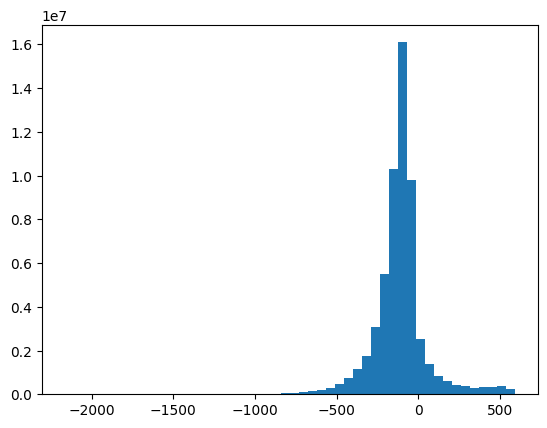

-2166.5361328125 592.295166015625


In [20]:
import matplotlib.pyplot as plt
plt.hist(all_pressure, bins=50)
plt.show()
print(all_pressure.min(), all_pressure.max())

# Save transform params

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def convert_numpy_types(obj):
    if isinstance(obj, dict):
        return {k: convert_numpy_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(v) for v in obj]
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.int32, np.int64)):
        return int(obj)
    else:
        return obj



# ---------- Define Dask-Compatible Transformation Functions ----------

# ---------- Full Transform Pipeline Using Dask ----------

def full_transform_pipeline(data):

    ### only for reporting errors
    mean = data.mean()
    std = data.std()
    min = data.min()
    max = data.max()

    params = {
        'min': min,
        'max': max ,
        'mean': mean,
        'std': std
    }

    return params


In [ ]:
vtk_surface_files[0]

'Data/cadillac/1_VTK_surface/cadillac_0/cadillac_0.vtp'

In [ ]:
mesh = pv.read(vtk_surface_files[1])
mesh

PolyData (0x7fa6e7facca0)
  N Cells:    827174
  N Points:   827376
  N Strips:   0
  X Bounds:   -2.116e+00, 2.131e+00
  Y Bounds:   -1.104e+00, 1.104e+00
  Z Bounds:   -2.792e-03, 2.082e+00
  N Arrays:   13

In [ ]:
import torch
import json
import numpy as np
from multiprocessing import Pool, cpu_count

# ----------------------- Parallel Data Loader -----------------------
def load_file(idx_file_pair):
    idx, file_path = idx_file_pair
    try:
        mesh = pv.read(file_path)

        scalar_data = {}
        for key in ['pressure']:
            if key in mesh.point_data:
                scalar_data[key] = mesh.point_data[key]
            else:
                scalar_data[key] = None

        bc_data = {}
        for key in ['fluid_density', 'inlet_velocity', 'viscosity_dynamic']:
            if key in mesh.point_data:
                bc_data[key] = mesh.point_data[key]
            elif key in mesh.field_data:
                bc_data[key] = mesh.field_data[key]
            else:
                bc_data[key] = None

        return mesh.points,scalar_data, bc_data
    except Exception as e:
        print(f"[ERROR] File {file_path}: {e}")
        return None


# ----------------------- Main Logic -----------------------
all_points = []


scalar_fields = {
    'pressure': []
}

bc_fields = {
    'fluid_density': [], 
    'inlet_velocity': [],
    'viscosity_dynamic': [], 
}

# Parallel load
with Pool(processes=min(cpu_count(), 150)) as pool:
    results = list(tqdm(pool.imap(load_file, zip(range(len(vtk_surface_files)), vtk_surface_files)), total=len(vtk_surface_files)))

print("aggregating results")
# Aggregate results
for result in results:
    if result is None:
        continue
    points, scalar_data, bc_data = result
    # add points to all_points
    all_points.append(points)
    # add scalar_data to scalar_fields
    for key, val in scalar_data.items():
        if val is not None:
            scalar_fields[key].append(val)
    # add bc_data to bc_fields
    for key, val in bc_data.items():
        bc_fields[key].append(val)




print("computing global mesh stats")
# ---------- Global mesh stats ----------
all_points_np = np.concatenate(all_points, axis=0)
mesh_stats = {
    "min": all_points_np.min(axis=0).tolist(),
    "max": all_points_np.max(axis=0).tolist(),
    "mean": all_points_np.mean(axis=0).tolist(),
    "std": all_points_np.std(axis=0).tolist()
}


# ---------- Transform Scalars ----------
print("transforming scalars")
scalar_output = {}
for name, values in scalar_fields.items():
    if len(values) == 0:
        continue
    all_data_np = np.concatenate(values)  # directly concatenate
    parameters = full_transform_pipeline(all_data_np)  # <-- replace with your numpy-based transform
    scalar_output[name] = parameters

print("normalizing BCs")
# ---------- Normalize BCs ----------
bc_max = {}
for key, matrices in bc_fields.items():
    all_bc_np = np.concatenate(matrices, axis=0)   # numpy concatenate
    bc_max_val = np.max(np.abs(all_bc_np))         # absolute max
    bc_max[key] = float(bc_max_val)


print("saving params")
# ---------- Save ----------

# Make sure save_dir is a file path, not a directory
save_path = save_dir if save_dir.endswith('.json') else save_dir + "/params.json"
with open(save_path, "w") as f:
    json.dump({
        "mesh_stats": mesh_stats,
        "scalars": convert_numpy_types(scalar_output),
        "boundary_conditions_max": convert_numpy_types(bc_max)
    }, f, indent=2)
    # Compute max and mean number of points per mesh
    num_points_list = [points.shape[0] for points, _, _ in results if points is not None]
    max_num_points = int(np.max(num_points_list))
    mean_num_points = float(np.mean(num_points_list))
    min_num_points = int(np.min(num_points_list))

    # Update JSON with these stats
    f.seek(0)
    params = json.load(open(save_path))
    params["max_num_points"] = max_num_points
    params["mean_num_points"] = mean_num_points
    params["min_num_points"] = min_num_points
    with open(save_path, "w") as f:
        json.dump(params, f, indent=2)

100%|██████████| 87/87 [00:02<00:00, 29.42it/s]



aggregating results
computing global mesh stats
transforming scalars
transforming scalars
normalizing BCs
saving params
normalizing BCs
saving params


# Test plot

In [26]:
import pyvista as pv
pv.start_xvfb()

sample_num = 10

/home/ansysai/mambaforge/envs/comparePhysicsLMenv3/lib/python3.12/site-packages/pyvista/plotting/utilities/xvfb.py:48: PyVistaDeprecationWarning: This function is deprecated and will be removed in future version of PyVista. Use vtk-osmesa instead.
  warnings.warn(


1. PLOT GT VTK

In [27]:
meshgt = pv.read(f'{save_dir}/{data_name}_{sample_num}/{data_name}_{sample_num}.vtp')
meshgt

PolyData (0x7fa6d97b0160)
  N Cells:    608466
  N Points:   608576
  N Strips:   0
  X Bounds:   -2.236e+00, 2.236e+00
  Y Bounds:   -1.007e+00, 1.007e+00
  Z Bounds:   4.033e-03, 1.320e+00
  N Arrays:   13

/home/ansysai/mambaforge/envs/comparePhysicsLMenv3/lib/python3.12/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


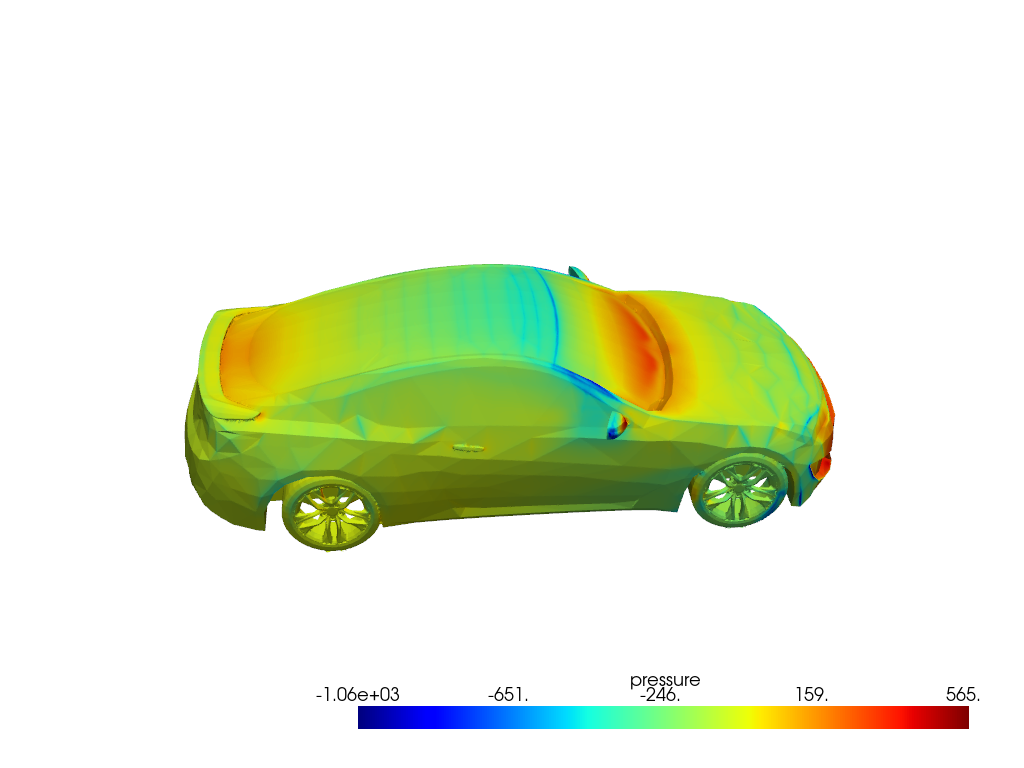

In [28]:
plotter = pv.Plotter()
plotter.add_mesh(meshgt, scalars='pressure', cmap='jet')

plotter.camera.azimuth = 40
plotter.show()

In [39]:
import os
import random

# Get all numbers from save_dir subfolders
numbers = [int(folder.split('_')[-1]) for folder in subfolders_1]

# Remove test_numbers from numbers to get train_numbers
train_numbers = [num for num in numbers if num not in test_numbers]

# Write train.txt and test.txt with folder names
with open(os.path.join(save_dir, 'train.txt'), 'w') as f:
    for num in train_numbers:
        # Find the folder that ends with this number
        folder_name = f"{data_name}_{num}"
        if folder_name in subfolders_1:
            f.write(f"{folder_name}\n")
        else:
            print(f"Warning: {folder_name} not found in subfolders_1")

with open(os.path.join(save_dir, 'test.txt'), 'w') as f:
    for num in test_numbers:
        # Find the folder that ends with this number
        folder_name = f"{data_name}_{num}"
        if folder_name in subfolders_1:
            f.write(f"{folder_name}\n")
        else:
            print(f"Warning: {folder_name} not found in subfolders_1")